In [1]:
import numpy as np
import os
import cst
import cst.interface
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

import filter
from retrieve_field_data_module import find_field_data_of_interest
from cst_modeler_helper import metal_thickness, copper_pure
from cst_modeler_helper import define_brick, define_components
from data_saving_helper import generate_file, list_datasets, save_data, retrieve_dataset

In [2]:
iteration_num = 3 # Iteration number must be greater than or equal to 1
x_lower_bound, x_upper_bound = -6, 6
y_lower_bound, y_upper_bound = -1.8, -0.2
max_track_width = 1.6
min_track_width = 0.4
bar_length_min, bar_length_max = 0.2, 3.6
step_size = 0.01
sample_points = int((x_upper_bound - x_lower_bound) / step_size) 

In [3]:
pass # This section generates the coordinates at iteration 0

x = np.arange(x_lower_bound, x_upper_bound, step_size)
y = np.ones(sample_points)

coordinates_upper_bound = np.array([(xi, y_upper_bound) for xi in x])
coordinates_lower_bound = np.array([(xi, y_lower_bound) for xi in x])
coordinates = np.array([coordinates_lower_bound, coordinates_upper_bound])

description = """This is a sample trail only optimization.
                 coordinates format: [coordinates_upper_bound, coordinates_lower_bound]"""

file_name = generate_file('iteration_0')
save_data(file_name, description, coordinates)

## Set Up the CST Environment 

### Create a microwave studio project or open an existing one

In [4]:
filename = f"iteration_{iteration_num}.cst"
path = f"D:\CSTStudioFiles\CouplerOptimization\iteration_{iteration_num}"
fullname = os.path.join(path, filename)
print(fullname)

D:\CSTStudioFiles\CouplerOptimization\iteration_3\iteration_3.cst


In [5]:
cst_handler = cst.interface.DesignEnvironment()

print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if os.path.exists(fullname):
    print("File exists.")
    mws = cst_handler.open_project(fullname)
    print("Project opened successfully.")
else:
    """
    print("File does not exist. Creating a new one.")
    mws = cst_handler.new_mws() # a Microwave Studio Project instance
    print("New MWS project created and opened successfully.")
    """
    raise FileExistsError(f"File {filename} does not exist.")

mws.save(fullname)
modeler = mws.modeler

Current time: 2024-11-15 12:07:08
File exists.
Project opened successfully.


## Data Post-Processing

### Retrieve E and H Data

Retrieve E and H forward and backward simulation data from the last iteration, and calculate the geometry updates.

In [6]:
file_path_last_iteration = f'coordinate_history/iteration_{iteration_num-1}.hdf5'
coordinates = retrieve_dataset(file_path_last_iteration, 'coordinates')
coordinates_shape = coordinates.shape
coordinates_flattened = coordinates.copy().reshape(-1, 2)

# Forward E field
file_path_e_forward = f'results/iteration_{iteration_num-1}_e_forward.h5'
e_forward_complex_values = find_field_data_of_interest(file_path_e_forward, coordinates_flattened, 'E-Field')

# Backward E field
file_path_e_backward = f'results/iteration_{iteration_num-1}_e_backward.h5'
e_backward_complex_values = find_field_data_of_interest(file_path_e_backward, coordinates_flattened, 'E-Field')

# Forward H field
file_path_h_forward = f'results/iteration_{iteration_num-1}_h_forward.h5'
h_forward_complex_values = find_field_data_of_interest(file_path_h_forward, coordinates_flattened, 'H-Field')

# Backward H field
file_path_h_backward = f'results/iteration_{iteration_num-1}_h_backward.h5'
h_backward_complex_values = find_field_data_of_interest(file_path_h_backward, coordinates_flattened, 'H-Field')

### Calculate Geometry Updates

In [7]:
p_in = 0.015
f0 = 5e9 # Hz
omega = 2 * np.pi * f0
eps0 = 8.8541878188e-12 # F/m
mu0 = 1.25663706127e-6 # N/A2
delta_t = 1e10

delta_p = []
for idx, coord in enumerate(coordinates_flattened):
    e_forward = e_forward_complex_values[idx]
    e_backward = e_backward_complex_values[idx]
    h_forward = h_forward_complex_values[idx]
    h_backward = h_backward_complex_values[idx]

    delta_p.append(1j * (-2 * omega) / p_in * 
                   (eps0 * np.dot(e_forward, e_backward) + mu0 * np.dot(h_forward, h_backward)))
    """
    print(f"coord: {coord}")
    print(f"\tdelta_p: {delta_p[-1]}")
    print(f"\tReal part: {delta_p[-1].real}")
    print(f"\t\t***{delta_p[-1].real / 1e11:.3f}***")
    """

delta_p = np.array(delta_p)
delta_p_real = delta_p.real / delta_t

In [8]:
coordinates_new = coordinates_flattened.copy()
coordinates_new[:, 1] += delta_p_real
coordinates_new = coordinates_new.reshape(coordinates_shape)

coordinates_upper_bound, coordinates_lower_bound = coordinates_new[0], coordinates_new[1]

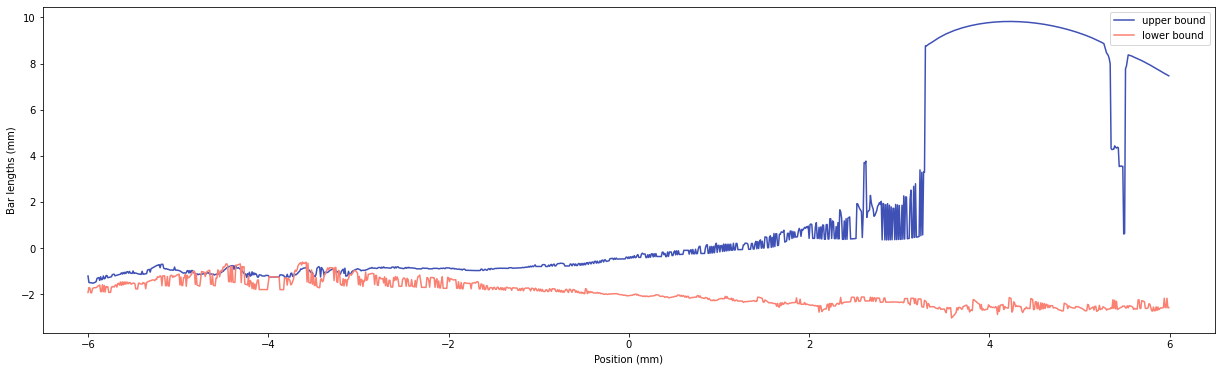

In [9]:
salmon_red = '#FA8072'
mint = '#40E0D0'
blue = '#3F51B5'

plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Bar lengths (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

In [10]:
for i in range(sample_points):
    upper_bound = np.max([coordinates_upper_bound[i, 1], coordinates_lower_bound[i, 1]])
    lower_bound = np.min([coordinates_upper_bound[i, 1], coordinates_lower_bound[i, 1]])
    coordinates_upper_bound[i, 1], coordinates_lower_bound[i, 1] = upper_bound, lower_bound

y_min, y_max = -3, 0.7
coordinates_upper_bound = np.clip(coordinates_upper_bound, None, y_max)
coordinates_lower_bound = np.clip(coordinates_lower_bound, y_min, None)

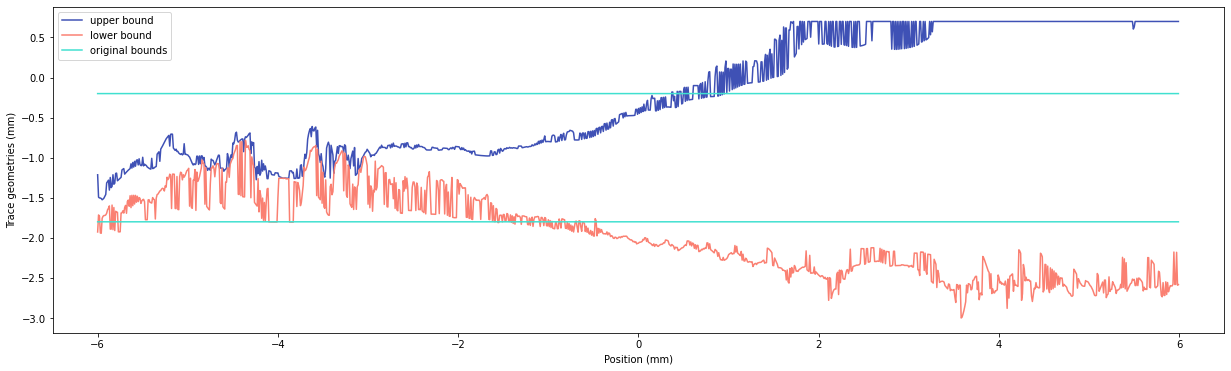

In [11]:
plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.plot(x, y_upper_bound * np.ones_like(coordinates_lower_bound[:, 1]), label='original bounds', color=mint)
plt.plot(x, y_lower_bound * np.ones_like(coordinates_lower_bound[:, 1]), color=mint)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Trace geometries (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

In [12]:
# Smooth the upper and lower bounds of the trail
coordinates_upper_bound[:, 1] = filter.gaussian_filter(coordinates_upper_bound[:, 1], 10)
coordinates_lower_bound[:, 1] = filter.gaussian_filter(coordinates_lower_bound[:, 1], 10)

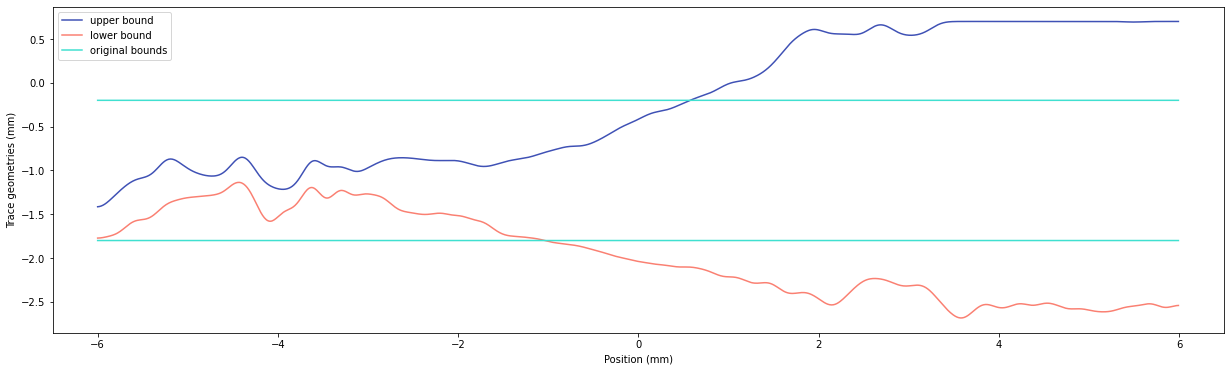

In [13]:
plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.plot(x, y_upper_bound * np.ones_like(coordinates_lower_bound[:, 1]), label='original bounds', color=mint)
plt.plot(x, y_lower_bound * np.ones_like(coordinates_lower_bound[:, 1]), color=mint)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Trace geometries (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

Limit the maximum track width to 0.4 - 1.6 mm.

In [14]:
for i in range(sample_points):
    width = coordinates_upper_bound[i, 1] - coordinates_lower_bound[i, 1]
    width = min([max_track_width, width])
    width = max([min_track_width, width])
    coordinates_lower_bound[i, 1] = coordinates_upper_bound[i, 1] - width

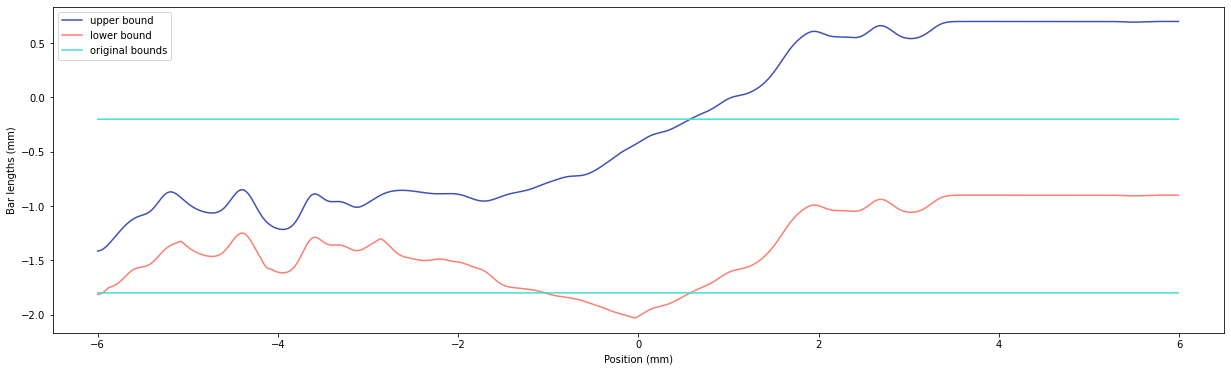

In [15]:
plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.plot(x, y_upper_bound * np.ones_like(coordinates_lower_bound[:, 1]), label='original bounds', color=mint)
plt.plot(x, y_lower_bound * np.ones_like(coordinates_lower_bound[:, 1]), color=mint)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Bar lengths (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

In [16]:
sample_rate = 30
sample_distance = 90

coord_upper_bound_start = np.array([(-6.01, -0.2)])
coord_lower_bound_start = np.array([(-6.01, -1.8)])
coord_upper_bound_end = np.array([(6+i*step_size, -0.2) for i in range(sample_rate)])
coord_lower_bound_end = np.array([(6+i*step_size, -1.8) for i in range(sample_rate)])

coordinates_upper_bound_extended = np.concatenate((coord_upper_bound_start, coordinates_upper_bound, coord_upper_bound_end))
coordinates_lower_bound_extended = np.concatenate((coord_lower_bound_start, coordinates_lower_bound, coord_lower_bound_end))

x_extended = np.arange(-6-step_size, 6+sample_rate*step_size, step_size)
print(x_extended)
x_extended_start_sampled = x_extended[:sample_distance+sample_rate:sample_rate]
x_extended_end_sampled = x_extended[-sample_distance-sample_rate-1::sample_rate]
print(x_extended_end_sampled)

y_ub_start_sampled = coordinates_upper_bound_extended[:sample_distance+sample_rate:sample_rate, 1]
y_ub_end_sampled = coordinates_upper_bound_extended[-sample_distance-sample_rate-1::sample_rate, 1]
y_lb_start_sampled = coordinates_lower_bound_extended[:sample_distance+sample_rate:sample_rate, 1]
y_lb_end_sampled = coordinates_lower_bound_extended[-sample_distance-sample_rate-1::sample_rate, 1]

print(y_ub_end_sampled)

cs_ub_start = CubicSpline(x_extended_start_sampled, y_ub_start_sampled, bc_type='natural')
cs_ub_end = CubicSpline(x_extended_end_sampled, y_ub_end_sampled, bc_type='natural')
cs_lb_start = CubicSpline(x_extended_start_sampled, y_lb_start_sampled, bc_type='natural')
cs_lb_end = CubicSpline(x_extended_end_sampled, y_lb_end_sampled, bc_type='natural')

y_up_start_interpolated = cs_ub_start(x_extended[:sample_distance])
y_up_end_interpolated = cs_ub_end(x_extended[-sample_distance:])
y_lp_start_interpolated = cs_lb_start(x_extended[:sample_distance])
y_lp_end_interpolated = cs_lb_end(x_extended[-sample_distance:])
print(f"{y_up_end_interpolated[0]}, {y_up_end_interpolated[-1]}")

coordinates_upper_bound[:sample_distance, 1] = y_up_start_interpolated
coordinates_upper_bound[-sample_distance:, 1] = y_up_end_interpolated
coordinates_lower_bound[:sample_distance, 1] = y_lp_start_interpolated
coordinates_lower_bound[-sample_distance:, 1] = y_lp_end_interpolated

[-6.01 -6.   -5.99 ...  6.27  6.28  6.29]
[5.09 5.39 5.69 5.99 6.29]
[ 0.69999873  0.69620558  0.69903601  0.7        -0.2       ]
0.6950893296777295, -0.2


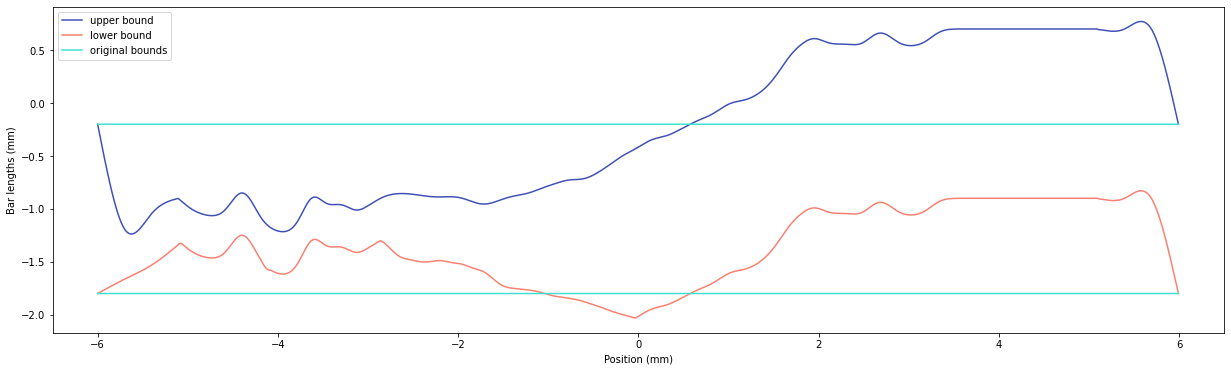

In [17]:
plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.plot(x, y_upper_bound * np.ones_like(coordinates_lower_bound[:, 1]), label='original bounds', color=mint)
plt.plot(x, y_lower_bound * np.ones_like(coordinates_lower_bound[:, 1]), color=mint)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Bar lengths (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

In [18]:
coordinates_upper_bound[:, 1] = np.clip(coordinates_upper_bound[:, 1], None, y_max)
coordinates_lower_bound[:, 1] = np.clip(coordinates_lower_bound[:, 1], y_min, None)

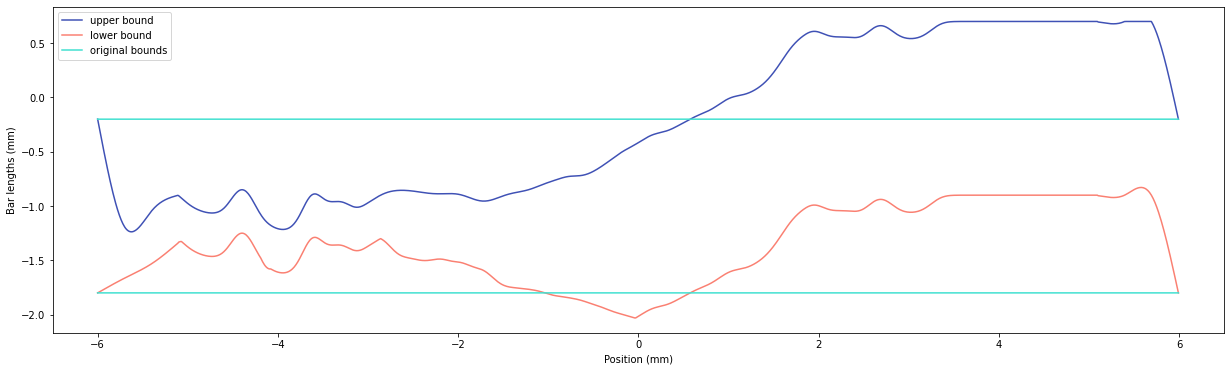

In [19]:
plt.figure(figsize=(21,6))

plt.plot(x, coordinates_upper_bound[:, 1], label='upper bound', color=blue)
plt.plot(x, coordinates_lower_bound[:, 1], label='lower bound', color=salmon_red)
plt.plot(x, y_upper_bound * np.ones_like(coordinates_lower_bound[:, 1]), label='original bounds', color=mint)
plt.plot(x, y_lower_bound * np.ones_like(coordinates_lower_bound[:, 1]), color=mint)
plt.legend()
plt.xlabel('Position (mm)')
plt.ylabel('Bar lengths (mm)')
plt.xlim(-6.5, 6.5)

plt.show()

In [20]:
description = """This is a sample trail only optimization.
                 coordinates format: [coordinates_upper_bound, coordinates_lower_bound]"""
file_path_coordinates = generate_file(f'iteration_{iteration_num}')
save_data(file_path_coordinates, description, np.array([coordinates_upper_bound, coordinates_lower_bound]))

## Update Geometries

### Create optimized geometries

In [21]:
component_names = ['power_line']
define_components(modeler=modeler, component_names=component_names)

for i in range(sample_points):
    define_brick(modeler=modeler,
                 brick_name=f'delta_line_{i}', component_name=component_names[0],
                 material=copper_pure,
                 x_range=(x[i], x[i] + step_size), 
                 y_range=(coordinates_lower_bound[i, 1], coordinates_upper_bound[i, 1]), 
                 z_range=(0, metal_thickness))

### Run the simulation and save

In [22]:
modeler.run_solver()
mws.save(fullname)